In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('cleaned_transactions.csv')
df.head()

,transaction_id,user_id,transaction_date,amount,payment_method,device,payment_status,failure_reason,retry_count,recovered_flag,recovery_status,revenue_lost,revenue_recovered,retry_bucket
0,1,1860,2024-05-24,1324.34,Debit Card,iOS,success,no_failure,0,0,success,0.00,0.0,no_retry
1,2,4772,2024-04-04,2237.72,Credit Card,iOS,success,no_failure,0,0,success,0.00,0.0,no_retry
2,3,4092,2024-02-02,3190.09,Debit Card,Web,success,no_failure,0,0,success,0.00,0.0,no_retry
3,4,1466,2024-02-25,940.45,Credit Card,Android,failed,network_error,0,0,lost,940.45,0.0,no_retry
4,5,5426,2024-05-04,3846.30,Credit Card,Web,success,no_failure,0,0,success,0.00,0.0,no_retry


Overall Revenue Metrics

In [2]:
total_revenue_attempted = df['amount'].sum()
total_revenue_recovered = df['revenue_recovered'].sum()
total_revenue_lost = df['revenue_lost'].sum()

recovery_pct = (total_revenue_recovered /
                (total_revenue_recovered + total_revenue_lost)) * 100

total_revenue_attempted, total_revenue_recovered, total_revenue_lost, recovery_pct

(np.float64(76155442.11),
 np.float64(3992232.53),
 np.float64(7719977.17),
 np.float64(34.08607455175602))

Revenue Status

In [3]:
revenue_status = (
    df.groupby('recovery_status')['amount']
    .sum()
    .reset_index()
)

revenue_status

,recovery_status,amount
0,lost,7719977.17
1,recovered,3992232.53
2,success,64443232.41


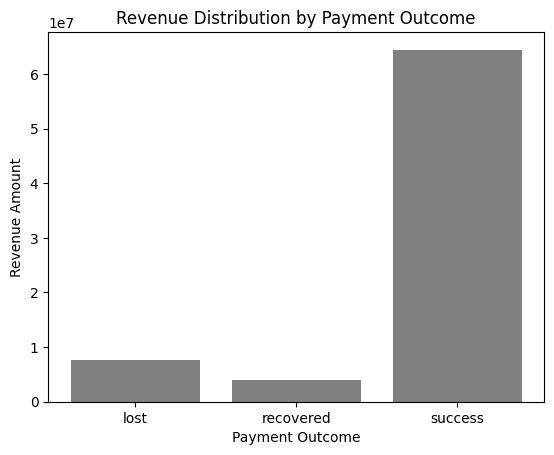

In [4]:
plt.figure()
plt.bar(revenue_status['recovery_status'],
        revenue_status['amount'],color='grey')
plt.title('Revenue Distribution by Payment Outcome')
plt.xlabel('Payment Outcome')
plt.ylabel('Revenue Amount')
plt.show()

Revenue Loss By Failure Reason

In [5]:
loss_by_reason = (
    df[df['recovery_status'] == 'lost']
    .groupby('failure_reason')['revenue_lost']
    .sum()
    .reset_index()
)

loss_by_reason

,failure_reason,revenue_lost
0,bank_decline,1176230.58
1,insufficient_funds,2389418.69
2,network_error,2651417.94
3,timeout,1502909.96


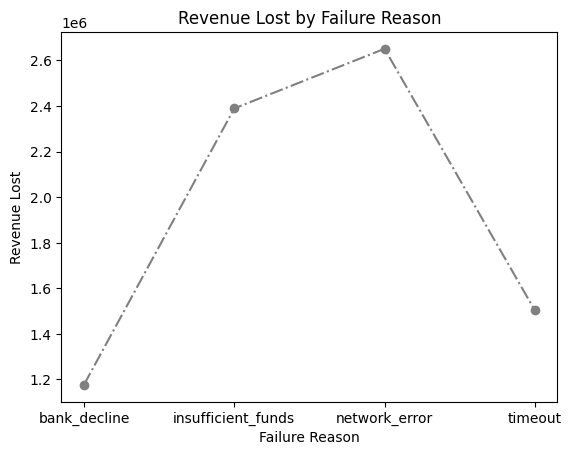

In [8]:
plt.figure()
plt.plot(loss_by_reason['failure_reason'],
        loss_by_reason['revenue_lost'],color='grey',linestyle='-.',marker='o')
plt.title('Revenue Lost by Failure Reason')
plt.xlabel('Failure Reason')
plt.ylabel('Revenue Lost')
plt.show()

Revenue Recovered by Payment Method

In [9]:
recovery_by_method = (
    df[df['recovery_status'] == 'recovered']
    .groupby('payment_method')['revenue_recovered']
    .sum()
    .reset_index()
)

recovery_by_method

,payment_method,revenue_recovered
0,Credit Card,1264651.71
1,Debit Card,1025109.06
2,Net Banking,394723.43
3,UPI,966205.59
4,Wallet,341542.74


In [13]:
import plotly.express as px

fig = px.funnel(
    recovery_by_method.sort_values('revenue_recovered', ascending=False),
    x='revenue_recovered',
    y='payment_method',
    color='payment_method',
    color_discrete_sequence=['lightblue', 'grey'],
    title='Revenue Recovered by payment method'
)

fig.show()

Revenue Loss Concentration (Pareto Insight)

In [16]:
loss_by_reason_sorted = loss_by_reason.sort_values(
    'revenue_lost', ascending=False
)

loss_by_reason_sorted['cumulative_pct'] = (
    loss_by_reason_sorted['revenue_lost'].cumsum() /
    loss_by_reason_sorted['revenue_lost'].sum() * 100
)

loss_by_reason_sorted

,failure_reason,revenue_lost,cumulative_pct
2,network_error,2651417.94,34.344894
1,insufficient_funds,2389418.69,65.296004
3,timeout,1502909.96,84.763808
0,bank_decline,1176230.58,100.000000


From the above revenue loss analysis we can conclude the following:

1.Significant revenue is recoverable through retries.

2.Bank decline and Timeout failures are high recovery opportunities.

3.Insufficient funds lead to permanent revenue loss.

4.Optimizing retry strategy can materially improve revenue.